## MML transformer

### 라이브러리

In [1]:
import torch
import math
import time
import pickle

import numpy as np
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from collections import Counter
from prettytable import PrettyTable
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from konlpy.tag import Okt
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import cosine_similarity

import random
import warnings
warnings.filterwarnings(action='ignore')


In [2]:
def seed_everything(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # 멀티 GPU 환경에서 seed 고정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False # cudnn을 끄는 것이 메모리 효율에는 좋을 수 있습니다. 하지만 속도가 느려질 수 있습니다.

seed_everything(42) # 원하는 seed 값으로 변경 가능

### 데이터 로드

In [3]:
# 데이터 로드 및 전처리 개선
def preprocess_data(csv_file_path):
    df = pd.read_csv(csv_file_path)
    text_column_name = 'cleaned_question_text'
    tone_label_name = 'tone_label'
    intent_label_name = 'intent_label'

    texts = df[text_column_name].tolist()
    tone_labels = df[tone_label_name].tolist()
    intent_labels = df[intent_label_name].tolist()

    tokenized_texts = [text.split() for text in texts]

    word_counts = Counter()
    for text in tokenized_texts:
        word_counts.update(text)

    special_tokens = ['<pad>', '<sos>', '<eos>', '<unk>']
    for token in special_tokens:
        word_counts[token] = 0

    vocab = {token: idx for idx, token in enumerate(word_counts)}
    vocab_size = len(vocab)

    numericalized_texts = [[vocab.get(token, vocab['<unk>']) for token in text] for text in tokenized_texts]
    numericalized_tone_labels = [int(label) for label in tone_labels] # tone label 정수형 변환
    numericalized_intent_labels = [int(label) for label in intent_labels] # intent label 정수형 변환

    return numericalized_texts, numericalized_tone_labels, numericalized_intent_labels, vocab, vocab_size

In [4]:

# Dataset 클래스 수정
class TextDataset(Dataset):
    def __init__(self, texts, tone_labels, intent_labels):
        self.texts = texts
        self.tone_labels = tone_labels
        self.intent_labels = intent_labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return torch.tensor(self.texts[idx]), torch.tensor(self.tone_labels[idx]), torch.tensor(self.intent_labels[idx])


In [5]:
# DataLoader 생성 함수 수정
def collate_batch(batch, pad_idx):
    texts = [item[0] for item in batch]
    tone_labels = torch.stack([item[1] for item in batch])
    intent_labels = torch.stack([item[2] for item in batch])
    padded_texts = torch.nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=pad_idx)
    return padded_texts, tone_labels, intent_labels


### transfomer 모델 class

In [6]:
# Multi-head attention Class 정의
class MyMHA(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()

        self.d_model = d_model
        self.num_heads = num_heads

        print(f'd_model : {d_model}, num_heads : {num_heads}')

        # 각 head의 임베딩 차원 : 각 머리당 처리될 차원 수
        self.d_head = d_model // num_heads
        print(f'각 머리당 처리될 차원 수 : {self.d_head}')

        self.W_q = nn.Linear(d_model, d_model)      # Linear() : 행렬 곱셈
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_z = nn.Linear(d_model, d_model)

    # 머리 나누기
    # 입력 데이터 모양: [50, 100, 512]
    # 출력 데이터 모양: [50, 8, 100, 64]
    def split_heads(self, x):
        # shape before : [50, 100, 512]
        batch_size = x.size(0)
        # 데이터 모양: [50, 100, 8, 64]
        x = x.view(batch_size, -1, self.num_heads, self.d_head) # -1 : '그대로 유지' 명령어
        x = x.transpose(1, 2)

        # batch_size_1, seq_len, d_model = x2.size()
        # x2 = x2.view(batch_size_1, seq_len, self.num_heads, self.d_head)  # shape after : (50, 100, 8, 64)
        # x2 = x2.transpose(1, 2)   # shape last : (50, 8, 100, 64)

        return x

    # 유사성 계산
    def dot_prod(self, q, k, v, mask=None):
        scores = torch.matmul(q, k.transpose(-2, -1)) / math.sqrt(self.d_head)

        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        probs = torch.softmax(scores, dim=-1)

        z = torch.matmul(probs, v)

        return z, probs # z와 probs 모두 반환

    # 머리 합치기

    def combine_heads(self, x):
        batch_size = x.size(0)
        Z = x.transpose(1, 2)
        Z = Z.contiguous().view(batch_size, -1, self.d_model) # 출력 데이터 모양: [50, 100, 512]
        return Z

    def forward(self, q, k, v, mask=None):
        Q = self.split_heads(self.W_q(q))
        K = self.split_heads(self.W_k(k))
        V = self.split_heads(self.W_v(v))

        attn_output, attn = self.dot_prod(Q, K, V, mask) # attn 받기

        attn_output = self.combine_heads(attn_output)
        output = self.W_z(attn_output)

        return output, attn # output과 attn 모두 반환

In [7]:
# feed forward class 구현

class MyFFN(nn.Module):
    def __init__(self, d_model, d_ff):
        super(MyFFN, self).__init__()

        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.linear2(x)

        return x

In [8]:
# 자연어 트랜스포머 인코더 구현

class My_Encoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(My_Encoder, self).__init__()

        self.mha = MyMHA(d_model, num_heads)
        self.ffn = MyFFN(d_model, d_ff)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, mask):
        # attention 가중치 저장
        z, attn = self.mha(x, x, x, mask) # attn 받기
        z = self.layer_norm(x + z)
        w = self.ffn(z)
        z = self.layer_norm(w + z)
        return z, attn # attn 반환

In [9]:
# 위치 인코딩 구현

class My_Position(nn.Module):
    def __init__(self, d_model):
        super(My_Position, self).__init__()
        self.d_model = d_model

    def pos_enc(self, seq_len):
        pos = torch.arange(0, seq_len, 1).float().unsqueeze(1)
        result = torch.zeros(seq_len, self.d_model)
        twoi = torch.arange(0, self.d_model, 2).float()
        result[:, 0::2] = torch.sin(pos / (10000 ** (twoi / self.d_model)))
        result[:, 1::2] = torch.cos(pos / (10000 ** (twoi / self.d_model)))
        return result.unsqueeze(0)

    def forward(self, x):
        seq_len = x.size(1)
        pos = self.pos_enc(seq_len)
        return pos


In [10]:
# 디코더 구현
class My_Decoder(nn.Module):
    def __init__(self, d_model, num_heads, d_ff):
        super(My_Decoder, self).__init__()

        self.mha1 = MyMHA(d_model, num_heads)
        self.mha2 = MyMHA(d_model, num_heads)
        self.ffn = MyFFN(d_model, d_ff)
        self.layer_norm = nn.LayerNorm(d_model)

    def forward(self, x, enc_out, src_mask, tgt_mask):
        print(f'디코더 입력 데이터 모양 : {x.shape}')
        # print(x[0])

        # 디코더 self attention 부분
        z = self.mha1(x, x, x, tgt_mask)
        z = self.layer_norm(z + x)        # self.layer_norm(z) + self.layer_norm(x) 와 같은 값이 될 수 없다.
        print(f'self attention 후 데이터 모양 : {z.shape}')

        # 디코더 cross attention
        y = self.mha2(z, enc_out, enc_out, src_mask)
        y = self.layer_norm(y + z)
        print(f'cross attention 후 데이터 모양 : {y.shape}')
        # print(y[0])

        # 마지막 feed forward
        w = self.ffn(y)
        z = self.layer_norm(w + y)
        print(f'feed forward 후 데이터 모양 : {z.shape}')
        # print(z[0])
        return z


In [11]:
# 전체 자연어 트랜스포머 구성

class My_Transformer(nn.Module):
    def __init__(self, d_model, num_heads, num_layers, d_ff, vocab_size, num_tone_labels, num_intent_labels):
        super(My_Transformer, self).__init__()

        self.enc_embed = nn.Embedding(vocab_size, d_model)
        self.pos_enc = My_Position(d_model)
        self.enc_layers = nn.ModuleList([My_Encoder(d_model, num_heads, d_ff) for _ in range(num_layers)])
        self.tone_classifier = nn.Linear(d_model, num_tone_labels)
        self.intent_classifier = nn.Linear(d_model, num_intent_labels)
        self.dropout = nn.Dropout(dropout)

    def forward(self, src):
        src_embed = self.enc_embed(src)
        pos = self.pos_enc(src_embed)
        src_embed = src_embed + pos
        enc_out = self.dropout(src_embed)
        all_encoder_attn_weights = [] # 모든 레이어의 attention weights를 저장할 리스트
        for layer in self.enc_layers:
            enc_out, attn_weights = layer(enc_out, None)
            all_encoder_attn_weights.append(attn_weights)
        
        tone_pred = self.tone_classifier(enc_out.mean(dim=1))
        intent_pred = self.intent_classifier(enc_out.mean(dim=1))

        return tone_pred, intent_pred, all_encoder_attn_weights

In [12]:
# vocab 클래스 정의
class My_Vocab:
    def __init__(self, vocab_dict):
        self.vocab = vocab_dict
        self.itos = {i:s for s,i in vocab_dict.items()} # index to string 추가

    def __len__(self):
        return len(self.vocab)

    def get(self, token, default=None):
      return self.vocab.get(token, default)
    
    def __getitem__(self, idx):
        return self.itos[idx]

    def save(self, path): # 저장 메서드 추가
        with open(path, 'wb') as f:
            pickle.dump(self.vocab, f)

    @classmethod
    def load(cls, path): # 로드 메서드 추가
        with open(path, 'rb') as f:
            vocab_dict = pickle.load(f)
        return cls(vocab_dict)

In [13]:
def extract_keywords(model, text, vocab, top_k=10, device="cpu"):
    model.eval()
    with torch.no_grad():
        if isinstance(text, str):
            tokenized_text = text.split()
        elif isinstance(text, list):
            tokenized_text = text
        else:
            raise TypeError("Input text must be a string or a list of strings.")

        numericalized_text = [vocab.get(token, vocab['<unk>']) for token in tokenized_text]
        src = torch.tensor([numericalized_text]).to(device)
        sequence_length = src.shape[1]

        _, _, all_encoder_attn_weights = model(src)
        print("Shape of all_encoder_attn_weights:", [attn.shape for attn in all_encoder_attn_weights])

        # 모든 레이어의 attention 가중치를 평균내는 올바른 방법
        all_attn = []
        for layer_attn in all_encoder_attn_weights:
            # 각 head의 attention 가중치를 평균냄 (핵심!)
            avg_head_attn = torch.mean(layer_attn[0], dim=0) # (seq_len, seq_len)
            all_attn.append(avg_head_attn)

        avg_attn_weights = torch.mean(torch.stack(all_attn), dim=0) # 레이어 평균
        print("Shape of avg_attn_weights:", avg_attn_weights.shape)

        word_importances = avg_attn_weights.mean(dim=0)
        print("Shape of word_importances:", word_importances.shape)

        # top_k 값 조정 (핵심 수정)
        k = min(top_k, len(word_importances)) # top_k 와 텐서 길이 중 작은 값을 선택

        top_indices = torch.topk(word_importances, k).indices.cpu().numpy()
        keywords = [tokenized_text[i] for i in top_indices]

        return keywords

In [15]:
def combined_keyword_extraction(model, text, vocab, top_k=10, device="cpu", w2v_model=None):
    attention_keywords = extract_keywords(model, text, vocab, top_k, device)

    okt = Okt()
    nouns = okt.nouns(text) # 명사 추출

    # TF-IDF
    tfidf_vectorizer = TfidfVectorizer()
    tfidf_matrix = tfidf_vectorizer.fit_transform([text])
    tfidf_scores = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_matrix.toarray()[0]))
    tfidf_keywords = sorted(tfidf_scores, key=tfidf_scores.get, reverse=True)[:top_k]

    # TextRank (간단한 구현, 필요에 따라 라이브러리 사용 가능)
    # 여기서는 명사 기반으로 간단하게 구현
    textrank_keywords = nouns[:top_k] # 단순 빈도수 기반으로 상위 k개 추출. 더 정교한 TextRank 구현은 pke, summa 등의 라이브러리 활용 추천.

    # 키워드 임베딩 (Word2Vec 활용)
    if w2v_model:
        combined_keywords = attention_keywords + tfidf_keywords + textrank_keywords
        keyword_embeddings = []
        valid_keywords = []

        for keyword in combined_keywords:
            try:
                embedding = w2v_model.wv[keyword]
                keyword_embeddings.append(embedding)
                valid_keywords.append(keyword)
            except KeyError:
                pass # Word2Vec 모델에 없는 단어는 제외

        if keyword_embeddings:
            avg_embedding = np.mean(keyword_embeddings, axis=0)
            similarities = cosine_similarity(keyword_embeddings, [avg_embedding])
            top_k_indices_embedding = np.argsort(similarities.flatten())[::-1][:top_k]
            final_keywords = [valid_keywords[i] for i in top_k_indices_embedding]
        else:
            final_keywords = attention_keywords # 임베딩이 없을 경우 attention 키워드 반환
    else:
        final_keywords = list(set(attention_keywords + tfidf_keywords + textrank_keywords))[:top_k]

    return final_keywords

In [16]:
# 가중치 수 출력 함수
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params += param
    print(table)
    print(f"전체 모델 가중치 수: {total_params}")
    return total_params


In [17]:
# 함수 정의 (데이터셋, 평가)
class TextDataset(Dataset):
    def __init__(self, texts, tone_labels, intent_labels):
        self.texts = texts
        self.tone_labels = tone_labels
        self.intent_labels = intent_labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = torch.tensor(self.texts[idx])  # 텍스트를 텐서로 변환
        tone_label = torch.tensor(self.tone_labels[idx])  # tone label을 텐서로 변환
        intent_label = torch.tensor(self.intent_labels[idx]) # intent label을 텐서로 변환
        return text, tone_label, intent_label


In [18]:
def evaluate(model, data_loader, tone_criterion, intent_criterion):
    model.eval()
    total_tone_loss = 0
    total_intent_loss = 0
    all_tone_preds = []
    all_tone_labels = []
    all_intent_preds = []
    all_intent_labels = []
    with torch.no_grad():
        for batch in data_loader:
            src_data, tone_labels, intent_labels = batch
            tone_pred, intent_pred, _ = model(src_data)

            tone_loss = tone_criterion(tone_pred, tone_labels)
            intent_loss = intent_criterion(intent_pred, intent_labels)

            total_tone_loss += tone_loss.item()
            total_intent_loss += intent_loss.item()

            all_tone_preds.extend(torch.argmax(tone_pred, dim=-1).cpu().numpy())
            all_tone_labels.extend(tone_labels.cpu().numpy())

            all_intent_preds.extend(torch.argmax(intent_pred, dim=-1).cpu().numpy())
            all_intent_labels.extend(intent_labels.cpu().numpy())
    return total_tone_loss / len(data_loader), all_tone_preds, all_tone_labels, total_intent_loss / len(data_loader), all_intent_preds, all_intent_labels

### 하이퍼 파라미터

In [19]:
# 하이퍼파라미터
d_model = 512
num_heads = 8
num_layers = 12
d_ff = 2048
dropout = 0.1
tot_epoch = 10
batch_size = 24
learning_rate = 1e-4


### 모델 학습

In [ ]:
# 데이터 로드 및 전처리
numericalized_texts, numericalized_tone_labels, numericalized_intent_labels, vocab, vocab_size = preprocess_data('data/question_categorize.csv')
pad_idx = vocab['<pad>']
index_to_word = {index: word for word, index in vocab.items()}

# 데이터 분할 (train, test, 계층적 샘플링 적용)
train_texts, test_texts, train_tone_labels, test_tone_labels, train_intent_labels, test_intent_labels = train_test_split(
    numericalized_texts, numericalized_tone_labels, numericalized_intent_labels, test_size=0.2, random_state=42, stratify=numericalized_intent_labels # stratify 추가
)

# 데이터셋 생성
train_dataset = TextDataset(train_texts, train_tone_labels, train_intent_labels)

# DataFrame으로 변환
def create_dataframe(texts, tone_labels, intent_labels):
    df = pd.DataFrame({
        'numericalized_text': texts,
        'tone_label': tone_labels,
        'intent_label': intent_labels
    })
    return df

train_df = create_dataframe(train_texts, train_tone_labels, train_intent_labels)
test_df = create_dataframe(test_texts, test_tone_labels, test_intent_labels)

# CSV 파일로 저장
train_df.to_csv('data/train_data.csv', index=False)
test_df.to_csv('data/test_data.csv', index=False)

print("Train data saved to train_data.csv")
print("Test data saved to test_data.csv")

# 원래 텍스트로 복원하여 저장
def restore_text(numericalized_text, index_to_word):
    return " ".join([index_to_word.get(idx, '<unk>') for idx in numericalized_text])

train_df['original_text'] = train_df['numericalized_text'].apply(lambda x: restore_text(x, index_to_word))
test_df['original_text'] = test_df['numericalized_text'].apply(lambda x: restore_text(x, index_to_word))

train_df.to_csv('data/train_data_with_text.csv', index=False)
test_df.to_csv('data/test_data_with_text.csv', index=False)

print("Train data with original text saved to train_data_with_text.csv")
print("Test data with original text saved to test_data_with_text.csv")

# 저장된 데이터 확인
print("\nTrain Data Head:")
print(train_df.head())
print("\nTest Data Head:")
print(test_df.head())

# 데이터셋 및 데이터로더 생성
train_dataset = TextDataset(train_texts, train_tone_labels, train_intent_labels)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda batch: collate_batch(batch, pad_idx))
print()
print("Train dataset size:", len(train_dataset))

test_dataset = TextDataset(test_texts, test_tone_labels, test_intent_labels)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=lambda batch: collate_batch(batch, pad_idx))
print("Test dataset size:", len(test_dataset))

num_tone_labels = len(set(numericalized_tone_labels))
num_intent_labels = len(set(numericalized_intent_labels))

In [ ]:
print("train_intent_label의 수 : ", Counter(train_intent_labels))
print("test_intent_label의 수 : ", Counter(test_intent_labels))

d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
+----------------------------------+------------+
|             Modules              | Parameters |
+----------------------------------+------------+
|         enc_embed.weight         |  2946048   |
|   enc_layers.0.mha.W_q.weight    |   262144   |
|    enc_layers.0.mha.W_q.bias     |    512     |
|   enc_layers.0.mha.W_k.weight    |   262144   |
|    enc_layers.0.mha.W_k.bias     |    512     |
|   enc_laye

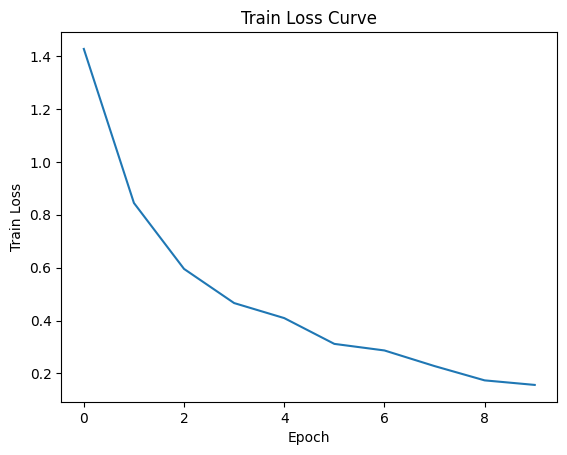

Test Results:
Tone - Accuracy: 0.9515, Precision: 0.9513, Recall: 0.9515, F1: 0.9513
Tone Confusion Matrix:
 [[304  28]
 [ 20 637]]
Tone Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       332
           1       0.96      0.97      0.96       657

    accuracy                           0.95       989
   macro avg       0.95      0.94      0.95       989
weighted avg       0.95      0.95      0.95       989

Intent - Accuracy: 0.9323, Precision: 0.9317, Recall: 0.9323, F1: 0.9318
Intent Confusion Matrix:
 [[ 59  11   6   4]
 [  9 538   3  14]
 [  1   4 122   3]
 [  4   8   0 203]]
Intent Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.74      0.77        80
           1       0.96      0.95      0.96       564
           2       0.93      0.94      0.93       130
           3       0.91      0.94      0.92       215

    accuracy                     

In [29]:
# 모델, 손실 함수, 최적화 알고리즘 정의
model = My_Transformer(d_model, num_heads, num_layers, d_ff, vocab_size, num_tone_labels, num_intent_labels)
count_parameters(model)

tone_criterion = nn.CrossEntropyLoss()
intent_criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=1e-3)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.2) # 1 에폭마다 학습률을 0.1배로 감소


# 학습 루프
begin_time = time.time()
print('학습 시작')
train_losses = [] # loss를 저장할 리스트

for epoch in range(tot_epoch):
    epoch_start_time = time.time()

    # 훈련 루프
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        src_data, tone_labels, intent_labels = batch
        optimizer.zero_grad()
        tone_pred, intent_pred, _ = model(src_data)
        tone_loss = tone_criterion(tone_pred, tone_labels)
        intent_loss = intent_criterion(intent_pred, intent_labels)
        loss = tone_loss + intent_loss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 훈련 데이터에 대한 예측
    train_tone_preds = []
    train_intent_preds = []
    train_tone_labels = []
    train_intent_labels = []
    with torch.no_grad():
        for batch in train_dataloader:
            src_data, tone_labels, intent_labels = batch
            tone_pred, intent_pred, _ = model(src_data)
            train_tone_preds.extend(torch.argmax(tone_pred, dim=1).tolist())
            train_intent_preds.extend(torch.argmax(intent_pred, dim=1).tolist())
            train_tone_labels.extend(tone_labels.tolist())
            train_intent_labels.extend(intent_labels.tolist())

    # 훈련 데이터에 대한 혼동 행렬 및 분류 보고서 (tone)
    train_tone_cm = confusion_matrix(train_tone_labels, train_tone_preds)
    train_tone_cr = classification_report(train_tone_labels, train_tone_preds)
    print("Train Tone Confusion Matrix:\n", train_tone_cm)
    print("Train Tone Classification Report:\n", train_tone_cr)

    # 훈련 데이터에 대한 혼동 행렬 및 분류 보고서 (intent)
    train_intent_cm = confusion_matrix(train_intent_labels, train_intent_preds)
    train_intent_cr = classification_report(train_intent_labels, train_intent_preds)
    print("Train Intent Confusion Matrix:\n", train_intent_cm)
    print("Train Intent Classification Report:\n", train_intent_cr)
        
    train_losses.append(train_loss/len(train_dataloader)) # 에폭별 평균 loss 저장

    epoch_end_time = time.time()
    print(f"Epoch {epoch+1}/{tot_epoch}, Train Loss: {train_loss/len(train_dataloader):.4f}")
    print(f"Time: {epoch_end_time-epoch_start_time:.2f}s") # 각 에폭의 시간만 출력
    print()
    # scheduler.step()

print('학습종료')

plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Train Loss')
plt.title('Train Loss Curve')
plt.show()

# 모델 저장 (학습 후)
torch.save({
    'model_state_dict': model.state_dict(),
    'vocab': vocab,
    'd_model': d_model,
    'num_heads': num_heads,
    'num_layers': num_layers,
    'd_ff': d_ff,
    'dropout': dropout,
    'num_tone_labels': num_tone_labels,
    'num_intent_labels' : num_intent_labels
}, "model/llm_transformer.pt") # 모델 전체 저장


# 모든 훈련이 끝난 후 테스트 진행
test_tone_loss, all_tone_preds, all_tone_labels, test_intent_loss, all_intent_preds, all_intent_labels = evaluate(model, test_dataloader, tone_criterion, intent_criterion)

# test_tone_loss, all_tone_preds, all_tone_labels = evaluate(model, test_dataloader, tone_criterion)
# test_intent_loss, all_intent_preds, all_intent_labels = evaluate(model, test_dataloader, intent_criterion)

tone_accuracy = accuracy_score(all_tone_labels, all_tone_preds)
tone_precision, tone_recall, tone_f1, _ = precision_recall_fscore_support(all_tone_labels, all_tone_preds, average='weighted')
tone_cm = confusion_matrix(all_tone_labels, all_tone_preds)
tone_cr = classification_report(all_tone_labels, all_tone_preds)

intent_accuracy = accuracy_score(all_intent_labels, all_intent_preds)
intent_precision, intent_recall, intent_f1, _ = precision_recall_fscore_support(all_intent_labels, all_intent_preds, average='weighted')
intent_cm = confusion_matrix(all_intent_labels, all_intent_preds)
intent_cr = classification_report(all_intent_labels, all_intent_preds)

print("Test Results:") # 테스트 결과임을 명시
print(f"Tone - Accuracy: {tone_accuracy:.4f}, Precision: {tone_precision:.4f}, Recall: {tone_recall:.4f}, F1: {tone_f1:.4f}")
print("Tone Confusion Matrix:\n", tone_cm)
print("Tone Classification Report:\n", tone_cr)

print(f"Intent - Accuracy: {intent_accuracy:.4f}, Precision: {intent_precision:.4f}, Recall: {intent_recall:.4f}, F1: {intent_f1:.4f}")
print("Intent Confusion Matrix:\n", intent_cm)
print("Intent Classification Report:\n", intent_cr)

print(f'총 학습 시간 : {time.time() - begin_time}')

### 모델 저장 및 어휘 사전(vocab) 저장

In [23]:
# 모델 저장 (학습 후)
torch.save(model.state_dict(), "model/llm_transformer_weights.pt")
print("모델 가중치 저장 완료")


모델 가중치 저장 완료


### 단어추출

In [ ]:
# *** 핵심 단어 추출 (학습 및 테스트 이후) ***
sample_text = test_df['original_text'].iloc[0] # 테스트 데이터 중 하나 선택
print("Original Text:", sample_text)

# 빈 텍스트 또는 토큰화 후 길이가 0인 경우 처리
if not sample_text or not sample_text.split():
    keywords = []  # 빈 리스트 반환
else:
    keywords = extract_keywords(model, sample_text, vocab, top_k=20, device="cpu") # device 설정 중요
print("Extracted Keywords:", keywords)

# 전체 테스트 데이터에 대해 핵심 단어 추출 (선택적, 안정성 향상)
def extract_keywords_safe(text):
    if not text or not text.split():
        return []
    else:
        return extract_keywords(model, text, vocab, top_k=5, device="cpu")

test_df['keywords'] = test_df['original_text'].apply(extract_keywords_safe)
print(test_df.head())

In [ ]:
import pandas as pd
import re

# CSV 파일 읽어오기
try:
    df = pd.read_csv("data/question.csv", encoding='utf-8') # UTF-8 인코딩으로 읽기, 필요에 따라 encoding='cp949' 등으로 변경
except FileNotFoundError:
    print("Error: data/question.csv 파일을 찾을 수 없습니다.")
    exit()
except pd.errors.ParserError:
    print("Error: CSV 파일 파싱 중 오류가 발생했습니다. 파일 형식을 확인해주세요.")
    exit()

# "?" 제거하고 cleaned_question 열 생성
df['cleaned_question_text'] = df['question_text'].str.replace('?', '', regex=False) # regex=False로 정규표현식 사용 안 함

# 정규표현식으로 "?" 포함 다른 특수문자 제거 (필요한 경우)
# 특수문자 제거를 원할 경우 아래 주석을 해제하고 사용하세요.
# df['cleaned_question'] = df['question_text'].str.replace(r'[^\w\s]', '', regex=True)

# 변경된 DataFrame을 새로운 CSV 파일로 저장
try:
    df.to_csv("data/cleaned_question.csv", index=False, encoding='utf-8') # UTF-8 인코딩으로 저장
    print("cleaned_question.csv 파일이 성공적으로 생성되었습니다.")
except Exception as e:
    print(f"Error: 파일 저장 중 오류가 발생했습니다: {e}")

# 결과 확인 (선택적)
print(df.head())

In [26]:
# 모델 로드 (수정됨)
checkpoint = torch.load("model/llm_transformer.pt")
vocab = checkpoint['vocab']
vocab_size = len(vocab)
d_model = checkpoint['d_model']
num_heads = checkpoint['num_heads']
num_layers = checkpoint['num_layers']
d_ff = checkpoint['d_ff']
dropout = checkpoint['dropout'] # dropout 값은 로드하지만, 모델 생성 시에는 사용하지 않음
num_tone_labels = checkpoint['num_tone_labels']
num_intent_labels = checkpoint['num_intent_labels']

model = My_Transformer(d_model, num_heads, num_layers, d_ff, vocab_size, num_tone_labels, num_intent_labels) # dropout 없이 모델 생성
model.load_state_dict(checkpoint['model_state_dict']) # 가중치 로드
model.eval()
model.to("cpu")

# 키워드 추출
sample_text = test_texts[0]
keywords = extract_keywords(model, sample_text, vocab, top_k=20, device="cpu")
print("Extracted Keywords:", keywords)

# 전체 테스트 데이터에 대해 핵심 단어 추출
test_df = pd.DataFrame({'original_text': [restore_text(text, index_to_word) for text in test_texts]})
test_df['keywords'] = test_df['original_text'].apply(extract_keywords_safe)
print(test_df.head())

# --- Word2Vec 모델 학습 및 저장 (별도 실행 또는 필요할 때만 실행) ---
def train_word2vec(df, save_path="model/word2vec.model"):
    okt = Okt()
    corpus = [okt.nouns(text) for text in df['cleaned_question_text']]
    w2v_model = Word2Vec(corpus, vector_size=100, window=5, min_count=1, workers=4)
    w2v_model.save(save_path)
    print("Word2Vec 모델 저장 완료")

try:
    df = pd.read_csv("data/cleaned_question.csv")
    # df = pd.read_csv("data/question_categorize.csv")
    train_word2vec(df)
except FileNotFoundError:
    print("CSV 파일을 찾을 수 없습니다.")

# Word2Vec 모델 로드 (키워드 추출 시)
w2v_model = Word2Vec.load("model/word2vec.model")


d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
d_model : 512, num_heads : 8
각 머리당 처리될 차원 수 : 64
Shape of all_encoder_attn_weights: [torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10]), torch.Size([1, 8, 10, 10])]
Shape of avg_attn_weights: torch.Size([1

In [27]:
# combined_keyword_extraction 함수 사용 예시
results = []
for index, row in df.iterrows():
    text = row['cleaned_question_text']
    keywords_with_w2v = combined_keyword_extraction(model, text, vocab, top_k=5, device="cpu", w2v_model=w2v_model)
    keywords_without_w2v = combined_keyword_extraction(model, text, vocab, top_k=5, device="cpu")

    results.append({
        'index': index,
        'text': text,
        'keywords_with_w2v': keywords_with_w2v,
        'keywords_without_w2v': keywords_without_w2v
    })

results_df = pd.DataFrame(results)
results_df.to_csv("best_keyword_extraction_results.csv", encoding="utf-8-sig", index=False)
print("키워드 추출 완료 및 결과 저장 완료")

Shape of all_encoder_attn_weights: [torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7])]
Shape of avg_attn_weights: torch.Size([7, 7])
Shape of word_importances: torch.Size([7])
Shape of all_encoder_attn_weights: [torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7]), torch.Size([1, 8, 7, 7])]
Shape of avg_attn_weights: torch.Size([7, 7])
Shape of word_importances: torch.Size([7])
Shape of all_encoder_attn_weights: [torch.Size([1, 8, 8, 8]), torch.Size([1, 8, 8, 8]), torch.Size([1, 8, 8, 8]), torch.Size([